# 用训练得到的模型预测

同济子豪兄 2023-2-6

## 导入工具包

In [33]:

import os
os.chdir("D:\workplace\projects\mmsegmentation")
import numpy as np
import matplotlib.pyplot as plt
# matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

## 载入模型

In [34]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('D:\\workplace\\projects\\OpenMMLabCompPractise\\作业03\\result\\pspnet_r50_test.py')

In [35]:
#!pip install wasabi==0.9.1


In [36]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

UnsupportedOperation: fileno

In [38]:
# 初始化模型
checkpoint_path = 'D:\\workplace\\projects\\OpenMMLabCompPractise\\作业03\\result\\iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: D:\workplace\projects\OpenMMLabCompPractise\作业03\result\iter_800.pth


## 载入测试集图像，或新图像

In [39]:
img = mmcv.imread('E:\\data\\dataset\\Glomeruli-dataset\\images\\VUHSK_1702_39.png')

## 语义分割预测

In [40]:
result = inference_model(model, img)

In [41]:
result.keys()

['pred_sem_seg', 'seg_logits']

In [42]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [43]:
pred_mask.shape

(1024, 1024)

In [44]:
np.unique(pred_mask)

array([0, 1], dtype=int64)

## 可视化语义分割预测结果

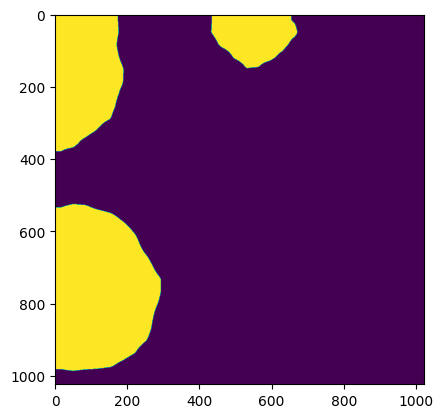

In [45]:
plt.imshow(pred_mask)
plt.show()

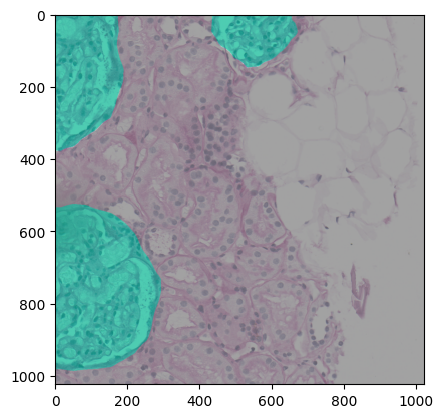

In [46]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

## 语义分割预测结果-连通域分析

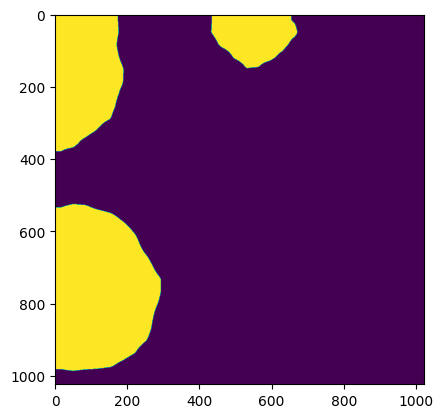

In [47]:
plt.imshow(np.uint8(pred_mask))
plt.show()

In [48]:
connected = cv2.connectedComponentsWithStats(np.uint8(pred_mask), connectivity=4)

In [49]:
# 连通域个数（第一个有可能是全图，可以忽略）
connected[0]

4

In [50]:
# 用整数表示每个连通域区域
connected[1].shape

(1024, 1024)

In [51]:
np.unique(connected[1])

array([0, 1, 2, 3], dtype=int32)

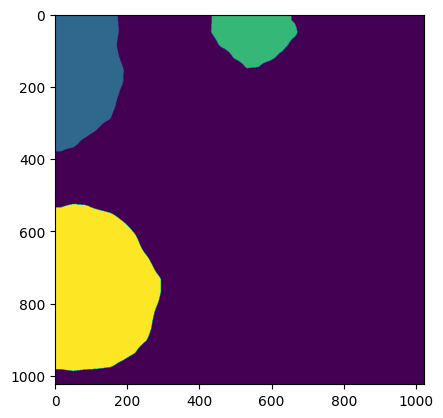

In [52]:
plt.imshow(connected[1])
plt.show()

In [53]:
# 每个连通域外接矩形的左上角X、左上角Y、宽度、高度、面积
connected[2]

array([[     0,      0,   1024,   1024, 853730],
       [     0,      0,    190,    380,  59316],
       [   432,      0,    239,    150,  26271],
       [     0,    526,    293,    462, 109259]], dtype=int32)

In [54]:
# 每个连通域的质心坐标
connected[3]

array([[589.67029506, 517.04715894],
       [ 82.77651898, 168.84378583],
       [548.97251722,  60.20848083],
       [124.43253187, 762.69303215]])

## 获取测试集标注

In [55]:
label = mmcv.imread('E:\\data\\dataset\\Glomeruli-dataset\\masks\\VUHSK_1702_39.png')

In [56]:
label_mask = label[:,:,0]

In [57]:
label_mask.shape

(1024, 1024)

In [58]:
np.unique(label_mask)

array([0, 1], dtype=uint8)

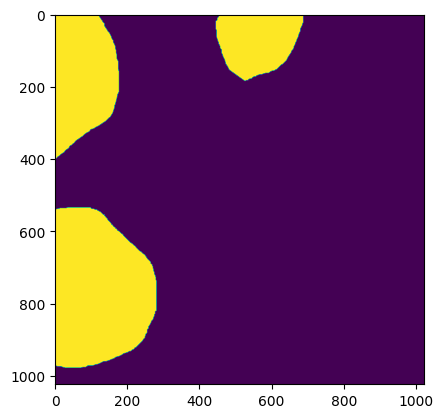

In [59]:
plt.imshow(label_mask)
plt.show()

## 对比测试集标注和语义分割预测结果

In [60]:
# 测试集标注
label_mask.shape

(1024, 1024)

In [61]:
# 语义分割预测结果
pred_mask.shape

(1024, 1024)

In [62]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [63]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [64]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [65]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

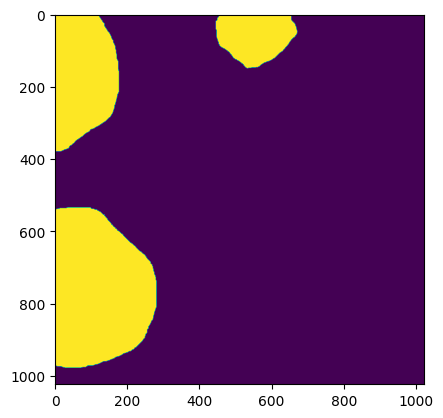

In [66]:
plt.imshow(TP)
plt.show()

In [67]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 10

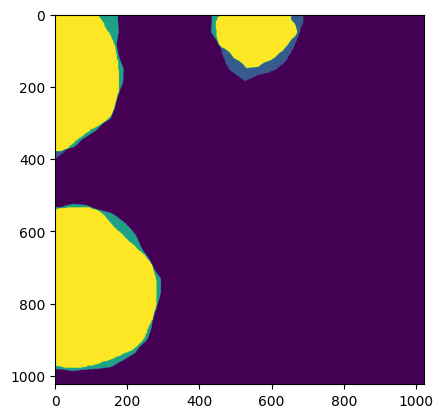

In [68]:
plt.imshow(confusion_map)
plt.show()

## 混淆矩阵

In [69]:
#!pip install sklearn
from sklearn.metrics import confusion_matrix

In [70]:
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

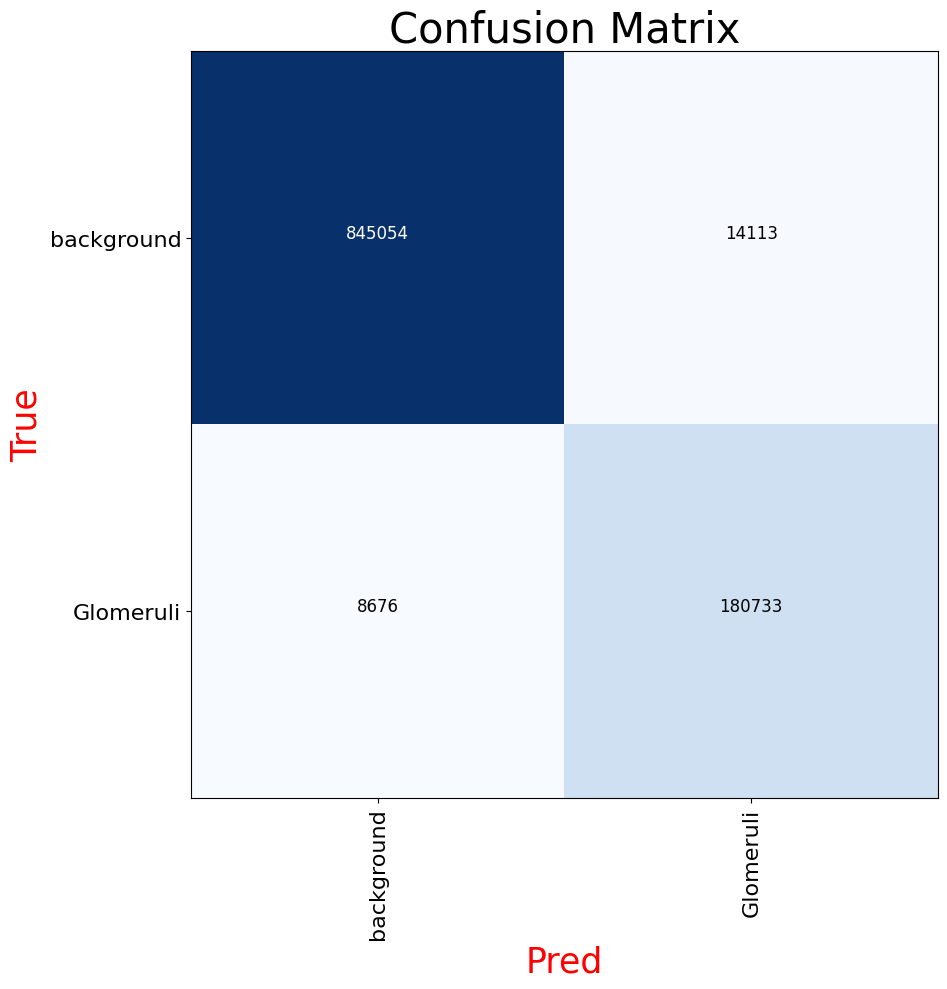

In [71]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.savefig('D:\\workplace\\projects\\OpenMMLabCompPractise\\作业03\\result\\混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
classes = ('background', 'Glomeruli')
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')